In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import backend as K

from matplotlib import pyplot as plt
import seaborn as sns

from datetime import date, datetime
import os
import warnings
import random
import time

from sklearn.preprocessing import MinMaxScaler

In [2]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = [15,8]
gpu = tf.config.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

# First read data into memory

In [3]:
data = pd.read_csv("../../train_files/preprocessed_train.csv")

In [4]:
data.head()

,RowId,Date,Code,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400.0,1.0,0.0,0,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500.0,1.0,0.0,0,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800.0,1.0,0.0,0,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300.0,1.0,0.0,0,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800.0,1.0,0.0,0,0.003026


# Data Transformation

The dataset contains rows which contain information about one stock at a specific time period and no information about any other stock. We will want to transform the data such that each row contains all information corresponding to that period. Our model will work by "sampling (without replacement)" a set of stocks (performed by creating a temporary dataset by taking the appropriate columns of the transformed dataset) and passing these samples of stock information individually until all possible stocks have been passed in a sample into the model.

To obtain this transformed dataset we will need to ensure all columns have the same length. To do this some columns will be padded with zeros, since stock information is added monotonically the data will be strictly left padded. Additionally, instead of raw open, high, low, close stock data we will use the percentage difference of these values from one time period to the next. Lastly the data will be normalized and a new column corresponding to previous target values will be added to each code series (note that target contains information for 2 days in the future so we will need to lag this column by 2). 

In [5]:
#Instead of date we will use days (the first date will be day 0)
data['Date'] = pd.to_datetime(data['Date'])

### Pad and Preprocessing
We need to fetch each code series to apply preprocessing correcly. Additionally pad if necessary.

In [6]:
def code_series(df, code, series_len=1201, holdout_num=32):
    """fetch series corresponding to a code returning series with length=series_len, padding missing values if necessary, takes percentage difference and scales data to [0,1]"""
    
    float_cols = ['Open','High','Low','Close','Volume','AdjustmentFactor','ExpectedDividend','LagTarget', 'h_l', 'o_c' ,'Target'] #lag target, h_l, o_c will be new features
    int_cols = ['SupervisionFlag']
    series = df[df['Code']==code].copy()
    
    #check length of series
    n = len(series)
    pad_rows = series_len - n
    series.set_index(pd.Index(np.arange(pad_rows, series_len)), inplace=True)
    
    #add features
    #lagged targets
    series['LagTarget'] = series['Target'].shift(periods=2, fill_value=0)

    #high/low over a day
    series['h_l'] = series['High'].values/series['Low'].values

    #open/close between dates
    o_c = np.ones(n, dtype=np.float64)
    o_c[1:] = (series.iloc[1:]['Open'].values) / (series.iloc[:-1]['Close'].values)
    series['o_c'] = o_c

    #use percentage change for columns 'Open','High','Low','Close','Volume'
    pct_diff = series.iloc[:,3:8].diff().values[1:]/series.iloc[:-1,3:8].values 
    series.iloc[1:,3:8] = pct_diff
    series = series.iloc[1:]
    
    series_float = series[float_cols].copy()
    series_int = series[int_cols].copy()

    #scale on train data (don't scale target)
    scaler = MinMaxScaler()
    scaler.fit(series_float.iloc[:-holdout_num, :-1].values)
    series_float.iloc[:-holdout_num, :-1] = scaler.transform(series_float.iloc[:-holdout_num, :-1].values)
    series_float.iloc[-holdout_num:, :-1] = scaler.transform(series_float.iloc[-holdout_num:, :-1].values)

    if pad_rows>0:
        zeros_float = np.zeros([pad_rows, len(float_cols)], dtype=np.float64)
        zeros_int = np.zeros([pad_rows, len(int_cols)], dtype=np.int64)
    
        series_float = pd.concat([pd.DataFrame(zeros_float, columns=float_cols), series_float], axis=0)
        series_int = pd.concat([pd.DataFrame(zeros_int, columns=int_cols), series_int], axis=0)
    
    series = pd.concat([series_int, series_float], axis=1)
    
    return series

### Create new transformed dataset
Now create new transformed dataset, each row will correspond to information on some day. 

In [7]:
def stretch_df(df, num_features=11, data_len=1200):
    """Transforms df such that the ith row contains all information for ith day"""
    #codes, wrap in dictionary 
    codes = df['Code'].unique()
    code_dict = {i:code for i,code in enumerate(codes)}
    #days since first day
    dates = df['Date'].unique()
    days = (dates - dates[0])/np.timedelta64(1, 'D')
    days = days.astype(np.int64)
    days = days/(4*365)  
    
    #make empty arrays to contain
    features = np.empty([data_len, 1+num_features*len(codes)])
    labels = np.empty([data_len, len(codes)])
    features[:,0] = days[1:]
    
    for j in range(len(codes)):
        series = code_series(df, codes[j])
        #columns 1+11i:1+11(i+1) for i from 0 to 1999 contain features for code j
        #where code_dict[i] = j 
        features[:, 1+(num_features)*j:1+num_features*(j+1)] = series.drop('Target', axis=1).values
        labels[:, j] = series['Target'].values
        
    return features, labels, code_dict

In [8]:
features, labels, code_dict = stretch_df(data)
features, labels = (features.astype(np.float32), labels.astype(np.float32)) #float 32 for tensorflow model

# Dataloader
To feed our data into the model we will need to essentially partition all stock codes into groups of some sample size then feed the appropriate columns into the model. To do this we will need a custom dataset iterator that 
1. creates samples of stocks
2. iterates over samples (each sample contains information of a several days)
3. fetches appropriate column of dataset corresponding to sampled stocks
4. maintains sample information in case we need to switch from train data to holdout data

In [9]:
class dataloader:
    def __init__(self, features, labels, sample_size=8, batch_size=32, t_size=16, t_step=4, holdout_num=32):
        """Creates minibatch of stocks, for each minibatch iterates over data returning feature columns with sample size s_size and iterates by size t_step."""
        #https://d2l.ai/chapter_recurrent-neural-networks/language-models-and-dataset.html
        #features and labels
        self.features = features
        self.labels = labels
        n_data, self.n_code = np.shape(labels) #number of dates, number of assets
        #variables to iterate over data
        self.s_size = sample_size #number of stocks to sample per bach
        self.t_size = t_size #number of rows per sample
        self.step = t_step #time step between each batch
        self.bsize = batch_size #number of samples per batch
        self.step = t_step #time step between each batch
        
        #variables to determine where to iterate
        self.s = None  #sample of stocks
        self.cur_s = None #current sample of stocks
        self.mode = None #iterate over train or test

        #create test, train
        assert batch_size%holdout_num==0
        self.n_train = n_data - holdout_num 
        self.n_test = holdout_num
        self.tr_x = self.features[:self.n_train]
        self.tr_y = self.labels[:self.n_train]
        self.te_x = self.features[-holdout_num-self.bsize+1:]
        self.te_y = self.labels[-holdout_num-self.bsize+1:]
        
    def sample(self):
        #creates samples of codes without replacement for each epoch
        num_samples = self.n_code//self.s_size
        samples = np.random.permutation(self.n_code) 
        samples = samples[:num_samples*self.s_size]
        samples = samples.reshape([num_samples, self.s_size]) #each row is a sample
        samples = samples.tolist()
        self.s = samples
        return len(samples)
        
    def next_sample(self):
        sample = self.s.pop()
        sample.sort()
        sample = np.array(sample, dtype=np.int32)
        self.cur_s = sample
        return sample
        
    def train(self):
        self.mode = 'train'
        
    def test(self):
        self.mode = 'test'
        
    def train_iter(self):
        offset = np.random.randint(0, self.step)
        
        #calculate number of possible samples (n) given dataset with offset
        datasize = self.n_train-offset
        n = (datasize-self.t_size)//self.step + 1
        #total number of batches b_n is then,
        b_n = (n)//self.bsize
        #total number of rows needed is then
        num_rows = self.t_size + (b_n*self.bsize-1)*self.step
        
        cols = [0]
        num_features = 9
    
        #now fetch columns
        for j in self.cur_s:
            cols.extend(range(1+num_features*j, 1+num_features*(j+1)))
            
        cols = np.array(cols)
        
        X_df = self.tr_x[-num_rows:, cols].copy()
        y_df = self.tr_y[-num_rows:, np.array(self.cur_s)].copy()
        
        def _window(df, pos):
            return df[pos:pos+self.t_size]
        
        for j in range(0, self.bsize*self.step*b_n, self.step*self.bsize):
            X = [_window(X_df, j+k*self.step) for k in range(self.bsize)]
            y = [y_df[j+k*self.step+self.t_size-1] for k in range(self.bsize)]
            #yield tf.constant(X, dtype=tf.float32), tf.expand_dims(tf.constant(y, dtype=tf.float32), axis=1)
            yield tf.constant(X, dtype=tf.float32), tf.constant(y, dtype=tf.float32)

            
    def test_iter(self):
        #number of batches 
        b_n = self.n_test//self.bsize
        cols = [0]
        num_features = 9
        
        for j in self.cur_s:
            cols.extend(range(1+num_features*j, 1+num_features*(j+1)))
            
        cols = np.array(cols)
        
        X_df = self.te_x[:, cols].copy()
        y_df = self.te_y[:, np.array(self.cur_s)].copy()
        
        def _window(df, pos):
            return df[pos:pos+self.t_size]
        
        for j in range(b_n):
            X = [_window(X_df, j+k) for k in range(self.bsize)]
            y = [y_df[j+k+self.t_size-1] for k in range(self.bsize)]
            #yield tf.constant(X, dtype=tf.float32), tf.expand_dims(tf.constant(y, dtype=tf.float32), axis=1)
            yield tf.constant(X, dtype=tf.float32), tf.constant(y, dtype=tf.float32)



    def __call__(self):
        if self.mode == 'train':
            return self.train_iter()
        else:
            return self.test_iter()
        
    def __iter__(self):
        if self.mode == 'train':
            return self.train_iter()
        else:
            return self.test_iter()



# Model
Our model works 3 steps
1. Feed sample of stocks into an embedding layer
2. Concatenate embed output with columns from dataset corresponding to the sample of stocks
3. Feed concatenated data into a GRU layer
4. The model goes through dense layers (with a dropout layer) and eventually returns the predicted target

In [10]:
class GRULayer(tf.keras.layers.Layer):
    def __init__(self, rnn_size, **kwargs):
        super(GRULayer, self).__init__(**kwargs)
        self.rnn = tf.keras.layers.GRU(rnn_size, return_state=True)

    def call(self, inputs, state):
        Y, state = self.rnn(inputs, state)
        return Y, state

    def begin_state(self, *args, **kwargs):
        return self.rnn.cell.get_initial_state(*args, **kwargs)
    
class EmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, out_size, bsize, **kwargs):
        super(EmbeddingLayer, self).__init__(**kwargs)
        self.emb = tf.keras.layers.Embedding(2000, out_size, input_length=8)
        self.flatten = tf.keras.layers.Flatten()
        self.bsize = bsize

    def call(self, inputs):
        out = self.emb(inputs)
        flat = self.flatten(tf.expand_dims(out, axis=0))
        return tf.tile(flat, [self.bsize, 1])
    
class DenseLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(DenseLayer, self).__init__(**kwargs)
        self.dropout = tf.keras.layers.Dropout(0.1)
        self.dense1 = tf.keras.layers.Dense(32,activation='tanh')
        self.dense2 = tf.keras.layers.Dense(16,activation='tanh')
        
        def wide_tanh(x):
            return tf.math.multiply(1.5, K.tanh(x))
        self.dense2 = tf.keras.layers.Dense(8, activation=wide_tanh)

    def call(self, inputs, **kwargs):
        Y = self.dense1(inputs)
        Y = self.dropout(Y, **kwargs)
        Y = self.dense2(Y)
        return Y
                                        

class GRUModel(tf.keras.Model):
    def __init__(self, bsize, rnn_size=32, embedding_out=6, **kwargs):
        super(GRUModel, self).__init__(**kwargs)
        self.bsize = bsize
        self.embedding = EmbeddingLayer(embedding_out, bsize)
        self.rnn = GRULayer(rnn_size)
        self.dense = DenseLayer()
        
        #skip
        self.dense1 = tf.keras.layers.Dense(64)
        self.dense2 = tf.keras.layers.Dense(32)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()


    def call(self, inputs, codes, state, **kwargs):
        #code embeddings to be concatenated after rnn layer
        code_embed = self.embedding(codes)
        #rnn layer
        y_rnn, state = self.rnn(inputs, state)
        #skip
        y_skip = tf.squeeze(inputs[:,-1,:])
        y_skip = self.dense1(y_skip)
        y_skip = self.bn(y_skip, **kwargs)
        y_skip = self.relu(y_skip)
        y_skip = self.dense2(y_skip)
        #add
        y_rnn = tf.math.add(y_rnn, y_skip)
        #concat
        d_in = tf.concat([code_embed, y_rnn], axis=1)
        y = self.dense(d_in, **kwargs)
        return y, state

    def begin_state(self, *args, **kwargs):
        return self.rnn.begin_state(batch_size=self.bsize, dtype=np.float32, *args, **kwargs)



# Train Model 

In [11]:
@tf.function
def train_step(x, y, sample, state):
    #computes loss of model for input x,y and applies gradients
    with tf.GradientTape() as g:
        y_hat, state = model(x, sample, state, training=True)
        loss_value = loss(y_hat, y)
    grads = g.gradient(loss_value, model.trainable_weights)
    grads = [tf.clip_by_norm(g, 2.5) for g in grads]
    opt.apply_gradients(zip(grads, model.trainable_weights))
    m_train.update_state(y, y_hat)
    return state

@tf.function
def test_step(x, y, sample, state):
    y_hat, state = model(x, sample, state, training=False)
    m_val.update_state(y, y_hat)
    return y_hat, state

In [12]:
model = GRUModel(bsize=32)
#model parameterse
loss = tf.keras.losses.MeanSquaredError()
state = model.begin_state()
opt = tf.keras.optimizers.Adadelta(0.1)

m_train = tf.keras.metrics.MeanSquaredError(name='train_mse')
m_val = tf.keras.metrics.MeanSquaredError(name='test_mse')

ds = dataloader(features, labels)
tf_ds = tf.data.Dataset.from_generator(ds, output_signature=
                                         (tf.TensorSpec(shape=(32,16,73), dtype=tf.float32), 
                                          tf.TensorSpec(shape=(32,8), dtype=tf.float32))).prefetch(tf.data.AUTOTUNE)
#for graphing 
t_l = []
v_l = []

preds = []
actuals = []

epochs = 8
for epoch in range(epochs):
    print("\nStart of epoch %d" %(epoch+1,))

    start_time = time.time()
    #reset metrics
    m_train.reset_state()
    m_val.reset_state()
    #partition stock assets
    num_samp = ds.sample()
    #iterate over each partition (sample of stocks)
    for i in range(num_samp):
        #fetch next sample 
        ds.train()
        sample = ds.next_sample()
        state = model.begin_state()
        #iterate over batches in sample
        for x_batch, y_batch in tf_ds:
            state = train_step(x_batch, y_batch, sample, state)

        ds.test()
        for x_batch_val, y_batch_val in tf_ds:
            y_hat, state = test_step(x_batch_val, y_batch_val, sample, state)
            
            if (epoch+1)==epochs:
                preds.append(y_hat.numpy())
                actuals.append(y_batch_val.numpy())

    train_mse = m_train.result()

    #display metrics after each epoch
    train_mse = train_mse.numpy()
    t_l.append(train_mse)
    print("Training acc over epoch: %.4f" % (train_mse,))


    val_mse = m_val.result().numpy()
    v_l.append(val_mse)
    print("Validation acc: %.4f" % (float(val_mse),))
        
    print("Time taken: %.2fs" %  (time.time()-start_time))
    
model.save_weights("/tmp/ckpoint")


Start of epoch 1
Training acc over epoch: 0.0768
Validation acc: 0.1471
Time taken: 34.68s

Start of epoch 2
Training acc over epoch: 0.0093
Validation acc: 0.0327
Time taken: 32.34s

Start of epoch 3
Training acc over epoch: 0.0034
Validation acc: 0.0064
Time taken: 32.20s

Start of epoch 4
Training acc over epoch: 0.0018
Validation acc: 0.0025
Time taken: 32.02s

Start of epoch 5
Training acc over epoch: 0.0013
Validation acc: 0.0014
Time taken: 32.29s

Start of epoch 6
Training acc over epoch: 0.0010
Validation acc: 0.0009
Time taken: 32.26s

Start of epoch 7
Training acc over epoch: 0.0008
Validation acc: 0.0008
Time taken: 32.55s

Start of epoch 8
Training acc over epoch: 0.0007
Validation acc: 0.0007
Time taken: 32.58s


# Graph Training/Validation Loss

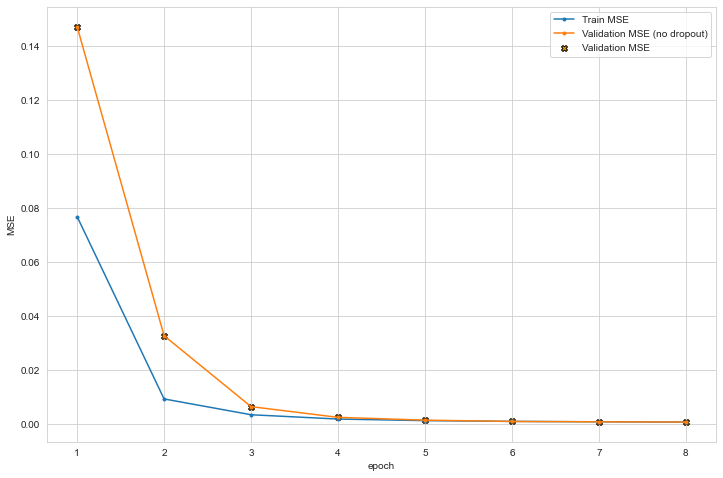

In [13]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(np.arange(len(t_l))+1, t_l, label='Train MSE', marker='.')
ax.plot(np.arange(len(t_l))+1, v_l, label='Validation MSE (no dropout)', marker='.')
ax.scatter(np.arange(len(t_l))+1, v_l, label='Validation MSE', marker='X', edgecolors='k', c='orange')
ax.set_xlabel('epoch')
ax.set_ylabel('MSE')
ax.legend(loc = 'upper right')
plt.show()

In [14]:
import matplotlib.ticker as mticker

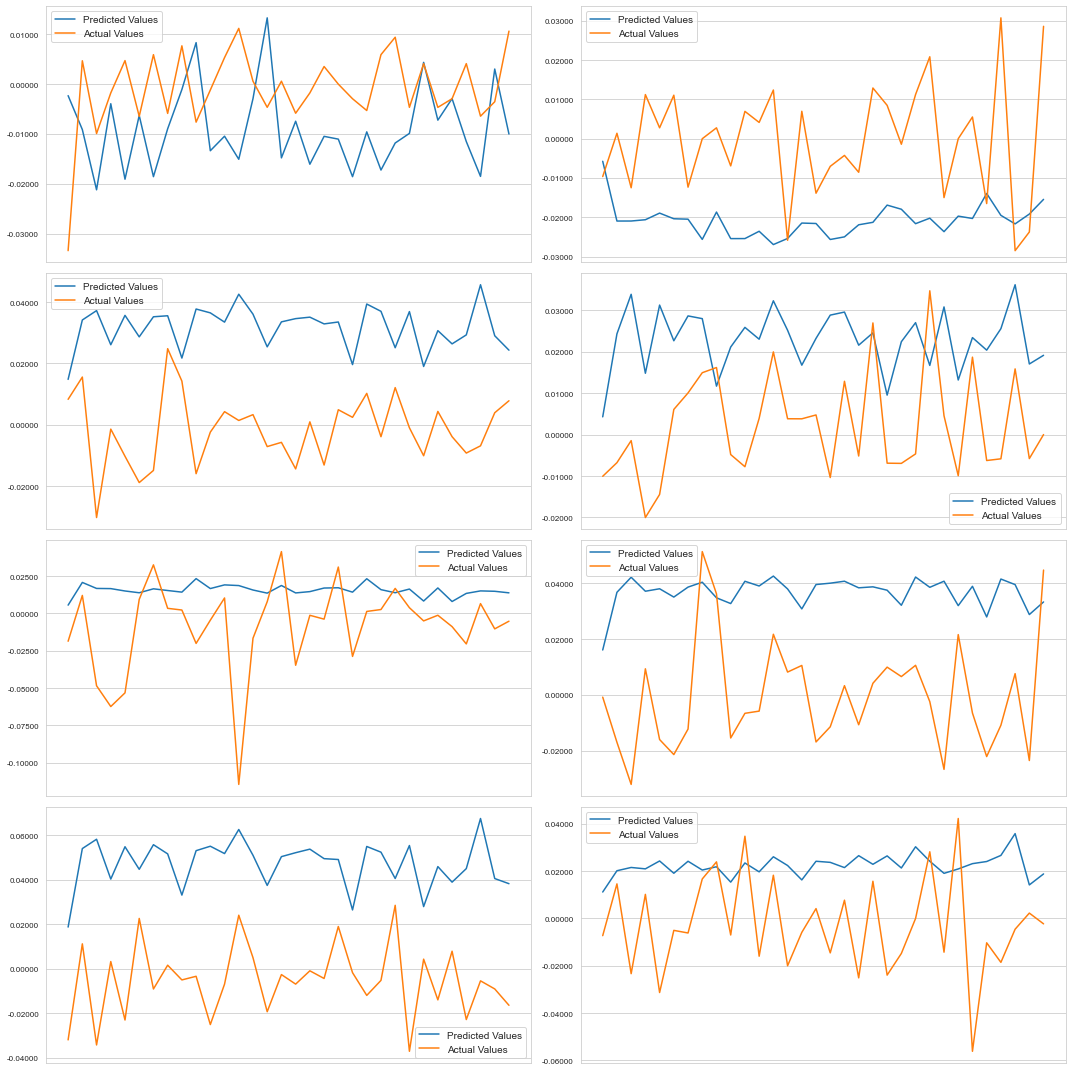

In [15]:
preds_0 = preds[0]
actuals_0 = actuals[0]

fig, axs = plt.subplots(4, 2, figsize=(15,15))
label_format = '{:,.5f}'

for i, ax in enumerate(axs.flatten()):
    ax.plot(preds_0[:,i], label="Predicted Values")
    ax.plot(actuals_0[:,i], label="Actual Values")
    ax.set_xticks([])
    ticks_loc = ax.get_yticks().tolist()
    ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_yticklabels([label_format.format(x) for x in ticks_loc], fontsize=8)
    ax.legend()
    
fig.tight_layout()
plt.show()